# Import

In [16]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

import ddpm_Time_Series_copy

import numpy as np
import pandas as pd
import torch

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset

#===========================

# Visualisation of the datasets 

In [17]:
# print the organisation of the datasets folder until the files using os.walk
import os

for root, dirs, files in os.walk('datasets'):
    level = root.replace('datasets', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)

        
#===========================

In [18]:
train_data = np.load(f'../datasets/UTS/WSD/1/train.npy')
print(train_data.shape)
print(train_data[0])
print(type(train_data))

(18235,)
50.0833320618
<class 'numpy.ndarray'>


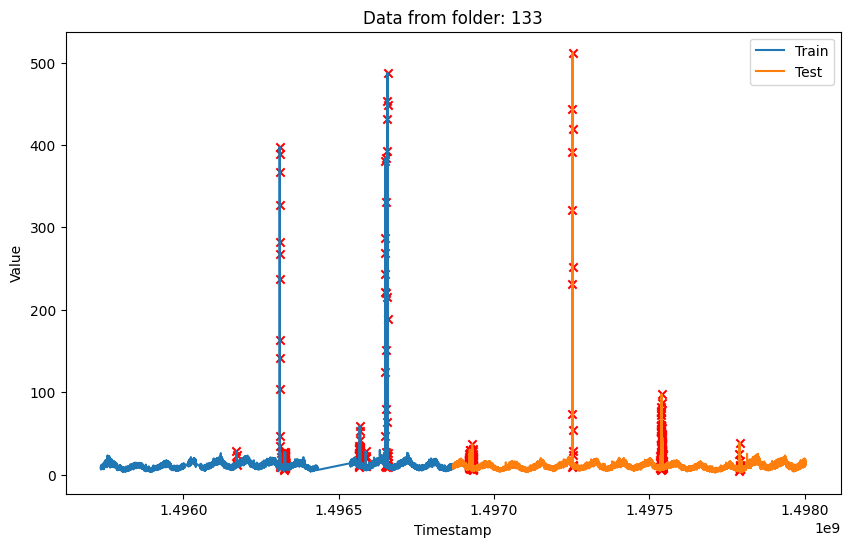

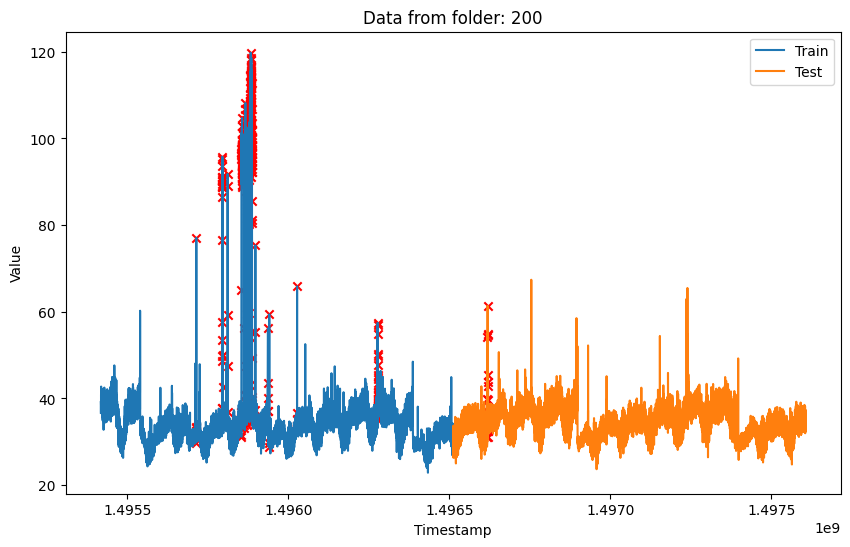

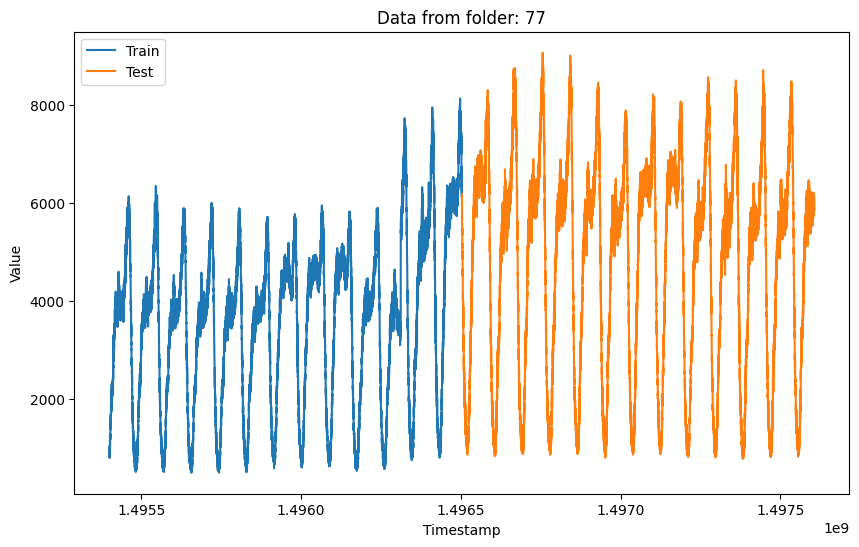

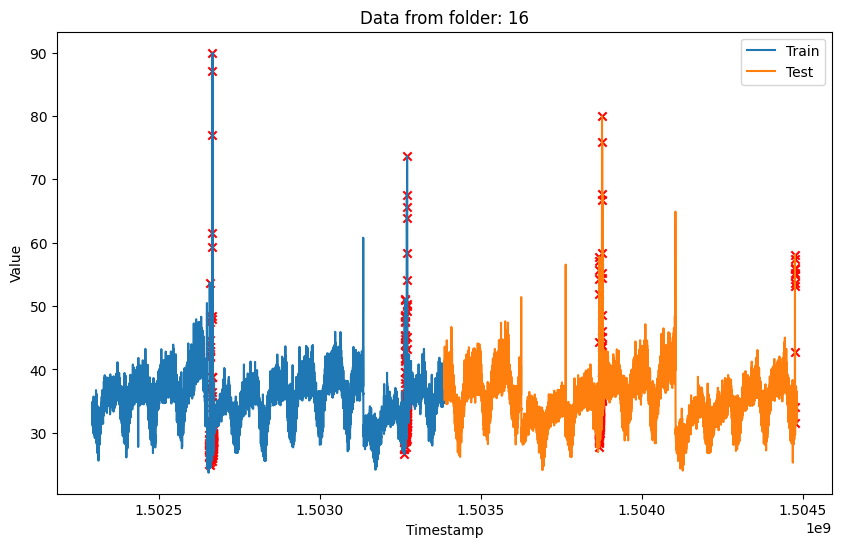

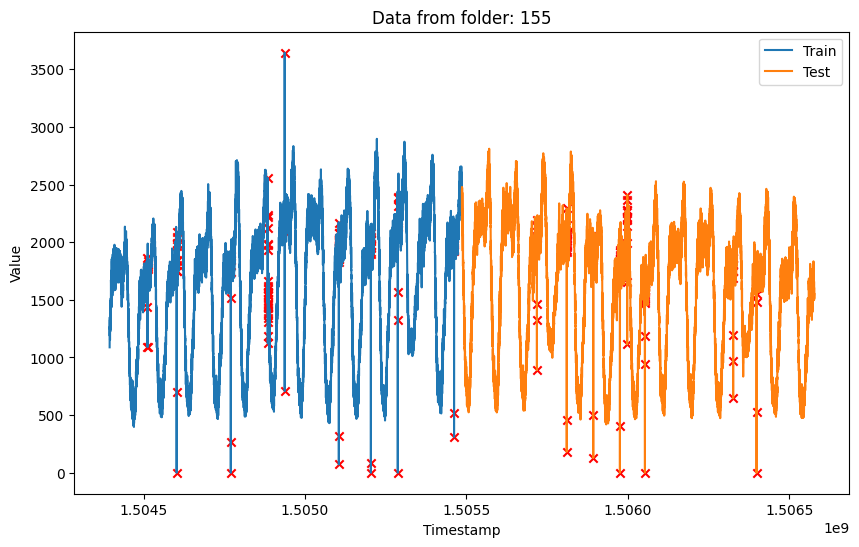

In [19]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

# Select 5 random folders
folders = os.listdir('../datasets/UTS/WSD')
folders = random.sample(folders, 5)

# Plot the train.npy and test.npy files in each selected folder
for folder in folders:
    train_data = np.load(f'../datasets/UTS/WSD/{folder}/train.npy')
    print
    test_data = np.load(f'../datasets/UTS/WSD/{folder}/test.npy')
    
    train_timestamp = np.load(f'../datasets/UTS/WSD/{folder}/train_timestamp.npy')
    test_timestamp = np.load(f'../datasets/UTS/WSD/{folder}/test_timestamp.npy')
    
    # Plot the train and test data in one figure using different colors
    plt.figure(figsize=(10, 6))
    plt.plot(train_timestamp, train_data, label='Train')
    plt.plot(test_timestamp, test_data, label='Test')
    
    # Plot anomalies as points in red
    train_label = np.load(f'../datasets/UTS/WSD/{folder}/train_label.npy')
    test_label = np.load(f'../datasets/UTS/WSD/{folder}/test_label.npy')
    
    for i, label in enumerate(train_label):
        if label:
            plt.scatter(train_timestamp[i], train_data[i], color='red', marker='x', label='Anomaly' if i == 0 else "")
    for i, label in enumerate(test_label):
        if label:
            plt.scatter(test_timestamp[i], test_data[i], color='red', marker='x', label='Anomaly' if i == 0 else "")
            
    plt.title(f"Data from folder: {folder}")
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    



In [20]:
    
#===========================
# compute the mean and std of the train data in the folder datasets/UTS/WSD/1
train_data = np.load('../datasets/UTS/WSD/1/train.npy')
mean = np.mean(train_data)
std = np.std(train_data)
print(mean, std)

#===========================
# Is train_data a 1D array or a 2D array?
print(train_data.ndim)

# In the variable data save = (train_data as a Tensor, train timestamp as a Tensor)
data = (torch.tensor(train_data), torch.tensor(train_timestamp))
print(data[0].shape, data[1].shape)
print(data)

36.78820118134014 11.438011591627744
1
torch.Size([18235]) torch.Size([18191])
(tensor([50.0833, 48.6667, 46.0833,  ..., 22.5000, 23.3000, 23.9000],
       dtype=torch.float64), tensor([1.5044e+09, 1.5044e+09, 1.5044e+09,  ..., 1.5055e+09, 1.5055e+09,
        1.5055e+09], dtype=torch.float64))


In [21]:
from torch.utils.data import DataLoader
dataloader = DataLoader( data , batch_size=32, shuffle=False, drop_last=True)

print(len(dataloader))
print(type(dataloader))
print(dataloader.batch_size)

for step, batch in enumerate(dataloader):
    print(step, batch[0].shape)

0
<class 'torch.utils.data.dataloader.DataLoader'>
32


# Model debugging

In [27]:
import ddpm_Time_Series_copy
!python ddpm_Time_Series_copy.py --data_path ../datasets/UTS/WSD/1 --output_dir output --num_epochs 3 --train_batch_size 64

Training model...
Batch shape: torch.Size([64, 100])
Noise shape: torch.Size([64, 100])
Noisy shape: torch.Size([64, 100])
Model output shape: torch.Size([64, 100])
Batch shape: torch.Size([64, 100])
Noise shape: torch.Size([64, 100])
Noisy shape: torch.Size([64, 100])
Model output shape: torch.Size([64, 100])
Batch shape: torch.Size([64, 100])
Noise shape: torch.Size([64, 100])
Noisy shape: torch.Size([64, 100])
Model output shape: torch.Size([64, 100])
Batch shape: torch.Size([64, 100])
Noise shape: torch.Size([64, 100])
Noisy shape: torch.Size([64, 100])
Model output shape: torch.Size([64, 100])
Batch shape: torch.Size([64, 100])
Noise shape: torch.Size([64, 100])
Noisy shape: torch.Size([64, 100])
Model output shape: torch.Size([64, 100])
Batch shape: torch.Size([64, 100])
Noise shape: torch.Size([64, 100])
Noisy shape: torch.Size([64, 100])
Model output shape: torch.Size([64, 100])
Batch shape: torch.Size([64, 100])
Noise shape: torch.Size([64, 100])
Noisy shape: torch.Size([64, 1

c:\Users\Ines\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")

Epoch 0:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0:  20%|██        | 1/5 [00:00<00:01,  2.70it/s, loss=1, step=0]

Epoch 0:  40%|████      | 2/5 [00:00<00:01,  2.98it/s, loss=1.01, step=1]

Epoch 0:  60%|██████    | 3/5 [00:00<00:00,  3.10it/s, loss=1.03, step=2]

Epoch 0:  80%|████████  | 4/5 [00:01<00:00,  3.15it/s, loss=0.993, step=3]

Epoch 0: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s, loss=0.976, step=4]

100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

Epoch 0: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s, loss=0.976, step=4]

Sampling: 100%|██████████| 50/50 [00:04<00:00, 10.24it/s]

Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:  20%|██        | 1/5 